In [10]:
import getpass
import os
import functools
import operator
from typing import Annotated, List, Dict, Optional, Any, Sequence, Union
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langchain.agents import (
    AgentExecutor,
    create_openai_tools_agent,
    create_openai_functions_agent,
    create_react_agent,
)

from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    PromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain_groq import ChatGroq
from langgraph.graph import END, START, StateGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

In [89]:
class ComparisonVariables(BaseModel):
    brand: str = Field(description="brand name of the product", max_length=20)
    industry: str = Field(description="industry of the product")
    year: int = Field(description="Year of the product information", ge=2000)


class ColorTrendVariables(BaseModel):
    brand: str = Field(description="brand name of the product", max_length=20)
    start_year: int = Field(description="Starting year of the product information")
    end_year: int = Field(description="Ending year of the product information")

In [90]:
@tool
def basetool(query):
    """This is the identity function return whatever user pass in query."""
    return query

In [91]:
llm = ChatOpenAI()

In [97]:
def create_agent(llm, tools: list, system_prompt):

    # prompt = ChatPromptTemplate.from_messages(
    #     [
    #         (
    #             "system",
    #             system_prompt,
    #         ),
    #         MessagesPlaceholder(variable_name="messages"),
    #         MessagesPlaceholder(variable_name="agent_scratchpad"),
    #         # MessagesPlaceholder(variable_name="format_instructions"),
    #         # MessagesPlaceholder(variable_name="ComparisonVariables")
    #     ]
    # )
    agent = create_openai_tools_agent(llm, tools, system_prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    # print(prompt)
    return executor

In [98]:
# comparision_prompt_template = """Tempalte {format_instructions}"""
# prompt = PromptTepmlate.from_template(template = comparision_prompt_template)
# system_prompt: str = prompt.format(format_instructions = parser.get_format_instructions())
# print(system_prompt)
# template
# must be in JSON format

# create_agent(_, _, system_prompt)

In [99]:
prompt_template_comparison = """You are responsible for handling queries that involve comparisons between the color family frequency of specific automobile brands and the overall auto industry for specified years. Focus on providing accurate comparisons based on the given criteria. Here are your key tasks:

    Comparison Focus:

    Answer questions that involve comparing the color family frequency of a specific automobile brand with the overall auto industry.
    Ensure the comparison is for the specified year or years mentioned in the query.
    Data Requirements:

    Use the provided data sets for both the specific automobile brand and the overall auto industry.
    Ensure the data is relevant to the specified year(s).
    Example Queries:

    "Can I see a comparison of the color family frequency for Audi and the auto industry in 2023?"
    "What does the color family frequency look like for BMW versus the auto industry over the last three years?"
    "How does the color family frequency for Toyota compare to the rest of the auto industry in 2022?"
    Output Format:
    {format_instructions}
    """
parser = JsonOutputParser(pydantic_object=ComparisonVariables)
# print(type(prompt_template_comparison))

In [100]:
# prompt_comp = PromptTemplate(
#     template=prompt_template_comparison,
#     partial_variables={"format_instructions": parser.get_format_instructions()},
# )
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            prompt_template_comparison,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
        # MessagesPlaceholder(variable_name="format_instructions"),
        # MessagesPlaceholder(variable_name="ComparisonVariables")
    ],
).partial(format_instructions=parser.get_format_instructions())


# system_prompt: str = prompt_comp.format(
#     format_instructions=parser.get_format_instructions()
# )
# print(type(system_prompt))
# print(system_prompt)

In [101]:
# llm_with_Comparison = llm.with_structured_output(
#     schema=ComparisonVariables, method="json_mode"
# )
comparison = create_agent(
    llm=llm, tools=[basetool], system_prompt=prompt
)
# executor = AgentExecutor(
#     agent=comparison, tools=[basetool], handle_parsing_errors=True
# )

In [102]:
prompt_color_trend = """You are responsible for handling queries that focus on the color trends and usage of specific automobile brands over various periods. Your main task is to provide detailed analysis and summaries of color families used by these brands. Here are your key tasks:

Trend Analysis Focus:

Answer questions about the color trends and usage for specific automobile brands over the given period.
Provide detailed analysis and insights based on historical data.
Data Requirements:

Use the provided data sets for the specific automobile brand.
Ensure the data covers the specified period mentioned in the query.
Example Queries:

"What color families have been used for Audi cars in the last ten years?"
"Can you tell me the color trends for Toyota vehicles over the past decade?"
"What were the main color families for BMW cars in the past five years?"
Output Format:
{format_instructions}
"""
parser = JsonOutputParser(pydantic_object=ColorTrendVariables)
# prompt_trend = PromptTemplate.from_template(
#     prompt_color_trend,
#     partial_variables={"format_instructions": parser.get_format_instructions()},
# )
# system_prompt: str = prompt_trend.format(
#     format_instructions=parser.get_format_instructions()
# )
# llm_with_trend = llm.with_structured_output(
#     schema=ColorTrendVariables,
# )
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            prompt_color_trend,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
        MessagesPlaceholder(variable_name="format_instructions"),
        # MessagesPlaceholder(variable_name="ComparisonVariables")
    ]
).partial(format_instructions=parser.get_format_instructions())

colortrend = create_agent(llm, [basetool], prompt)
# executor_2 = AgentExecutor(
#     agent=colortrend, tools=[basetool], handle_parsing_errors=True
# )

In [103]:
# executor.invoke(
#     {"input": "Which color families have Audi cars used most over the past five years?"}
# )

In [104]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [105]:
members = [
    "comparison",
    "colortrend",
]
system_prompt = """

You are tasked with routing user queries to the appropriate agent based on their content. 
agents : {members}
There are two groups of questions: Group 1 focuses on comparing the color family frequency of specific automobile brands with the overall auto industry for specified years. 
Group 2 focuses on the color trends and usage of specific automobile brands over various periods. 
Use the following guidelines to determine which agent to choose:

Comparision Agent:

Choose this agent if the question involves a comparison between a specific automobile brand and the overall auto industry for one or more specified years.
Look for keywords like "compare," "comparison," "year(s)," "industry," and specific brand names (e.g., Audi, BMW, Toyota).

Colortrend Agent:

Choose this agent if the question involves analyzing or listing the color families or trends of specific automobile brands over any given period.
Look for keywords like "color trends," "color families," "usage," "period," and specific brand names (e.g., Audi, BMW, Toyota).

Instructions for Differentiation:

Identify whether the query is about a comparison with the auto industry  or a focus on a specific brand's historical color usage .
Determine if the query involves specific years for a comparison  or a broader analysis of color trends over time .
"""

options = ["FINISH"] + members

function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above , who should act next?"
            "Or should we FINISH? Select one of : {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI()
# parser = PydanticOutputParser(pydantic_object=ComparisonVariables)

supervisor_chain = (
    prompt
    | llm.bind_functions(
        functions=[function_def],
        function_call="route",
    )
    | JsonOutputFunctionsParser()
)

In [106]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

    next: str

In [107]:
comparison_node = functools.partial(agent_node, agent=comparison, name="comparison")

colortrend_node = functools.partial(agent_node, agent=colortrend, name="colortrend")

In [108]:
workflow = StateGraph(AgentState)
workflow.add_node("comparison", comparison_node)
workflow.add_node("colortrend", colortrend_node)

workflow.add_node("supervisor", supervisor_chain)

for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

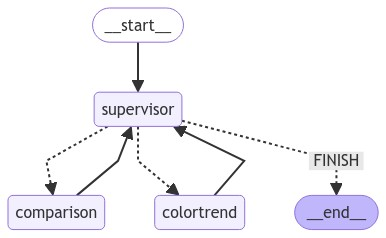

In [109]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [111]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                # content="Can I see a comparison of the color family frequency for Audi and the auto industry in 2023?",
                content="Can you list the colors Audi has used for their cars over the past five years?",
            )
        ]
    },
    {"recursion_limit": 15},
    debug=True,
):
    if "__end__" not in s:
        print(s)
        print("----")

[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'messages': [HumanMessage(content='Can you list the colors Audi has used for their cars over the past five years?')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [HumanMessage(content='Can you list the colors Audi has used for their cars over the past five years?')]
[1:tasks] Starting step 1 with 1 task:
- supervisor -> {'messages': [HumanMessage(content='Can you list the colors Audi has used for their cars over the past five years?')],
 'next': None}
{'supervisor': {'next': 'colortrend'}}
----
[1:writes] Finished step 1 with writes to 1 channel:
- next -> 'colortrend'
[2:tasks] Starting step 2 with 1 task:
- colortrend -> {'messages': [HumanMessage(content='Can you list the colors Audi has used for their cars over the past five years?')],
 'next': 'colortrend'}


ValueError: variable format_instructions should be a list of base messages, got The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"brand": {"description": "brand name of the product", "maxLength": 20, "title": "Brand", "type": "string"}, "start_year": {"description": "Starting year of the product information", "title": "Start Year", "type": "integer"}, "end_year": {"description": "Ending year of the product information", "title": "End Year", "type": "integer"}}, "required": ["brand", "start_year", "end_year"]}
``` of type <class 'str'>